In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

## Read graph

In [2]:
class ReadGraph:

  def _read_file(self, filename):
    edges = []
    min_val, max_val = 0, 0
    with open(filename, "r") as f:
      for line in f.readlines():
        values = list(map(lambda x:int(x), line.strip().split(",")))
        min_val = min((min_val, values[0], values[1]))
        max_val = max((max_val, values[0], values[1]))
        # if no weight is provided, give unit weight to all edges
        if len(values) == 2:
          values = (*values, 1)
        # make sure the edges are ordered
        if values[0] > values[1]:
          values = (values[0]-1, values[1]-1, values[2])
        edges.append(values)
    print(len(edges))
    return edges, min_val, max_val

  def _create_matrix(self, edges_and_weights, min_val, max_val):
    n_nodes = max_val - min_val + 1
    m = np.zeros((n_nodes, n_nodes))
    for (i, j, weight) in edges_and_weights:
      m[i][j] += weight
    print(m)
    A = m + m.T + np.diag(np.repeat(np.max(m) + 1, n_nodes))
    return A

  def create_affinity_matrix_from_file(self, filename):
    v = self._read_file(filename)
    A = self._create_matrix(*v)
    return A

  def calculate_laplacian_and_diagonal(self, A):
    D = np.diag(np.sum(A, 1))
    L = D - A
    return L, D

In [3]:
rd = ReadGraph()
A_1 = rd.create_affinity_matrix_from_file("example1.dat")
#print(A_1)
# L_1, D_1 = rd.calculate_laplacian_and_diagonal(A_1)
# A_2 = rd.create_affinity_matrix_from_file("example2.dat")
# L_2, D_2 = rd.calculate_laplacian_and_diagonal(A_2)

2196
[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Find communities

In [4]:
def get_ordered_eigenvalues_and_vectors(M):
  eigenvalues, eigenvectors = np.linalg.eig(M)
  sorting = np.argsort(eigenvalues)[::-1]
  return eigenvalues[sorting], eigenvectors[:, sorting]

In [5]:
def find_eigengap(eigenvalues):
  b = np.zeros(eigenvalues.shape)
  b[1:] = eigenvalues[:-1]
  differences = b - eigenvalues
  return np.argmax(differences)

In [6]:
def plot_eigenvalues(eigenvalues):
  plt.scatter(np.arange(eigenvalues.shape[0]), eigenvalues)
  plt.show()

def plot_clusters(eigenvalues, eigenvectors):
  k = find_eigengap(eigenvalues)
  plt.scatter(eigenvectors[:, k - 1], eigenvectors[:, k])
  plt.show()
  return k, np.argsort(eigenvectors[:, k])

In [7]:
eva_2, eve_2 = get_ordered_eigenvalues_and_vectors(A_2)
plot_eigenvalues(eva_2)
k_2, node_sorting_2 = plot_clusters(eva_2, eve_2)
_ = plt.plot(eve_2[:, k_2][node_sorting_2])

NameError: name 'A_2' is not defined

## Paper algorithm

In [ ]:
class SpectralClustering:

  def _compute_L(self, A):
    D_sqrt = np.diag(np.sum(A, 1)**(-0.5))
    return D_sqrt @ A @ D_sqrt

  def _compute_X(self, L, k):
    values, vectors = get_ordered_eigenvalues_and_vectors(L)
    X = vectors[:, :k]
    normalisation_vector = np.sum(X, 1)[:, None]
    Y = X / normalisation_vector**2
    return Y

  def _kmeans(self, Y, k):
    kmeans = KMeans(k, n_init="auto")
    Y_imputed = SimpleImputer(strategy="constant").fit_transform(Y)
    predictions = kmeans.fit_predict(Y_imputed)
    return predictions

  def find_clusters(self, A, k):
    L = self._compute_L(A)
    Y = self._compute_X(L, k)
    assignments = self._kmeans(Y, k)
    return assignments

In [ ]:
sc = SpectralClustering()
assignments_2 = sc.find_clusters(A_2, 2)

In [ ]:
assignments_2

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

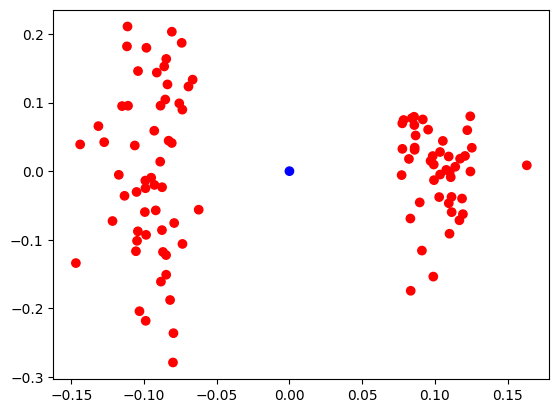

In [ ]:
plt.scatter(eve_2[:, k_2 - 1], eve_2[:, k_2], c=np.array(["r", "b", "yellow", "g"])[assignments_2])

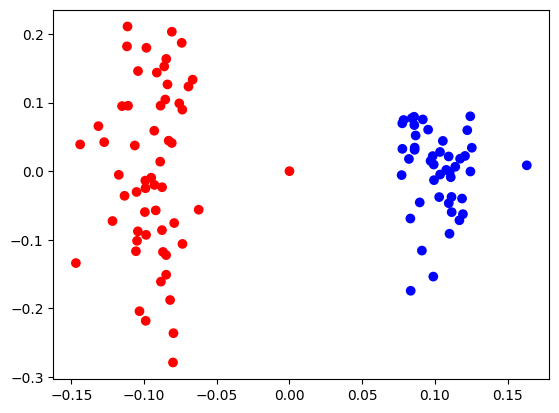

In [ ]:
plt.scatter(eve_2[:, k_2 - 1], eve_2[:, k_2], c=np.array(["r", "b"])[KMeans(2, n_init=10).fit_predict(eve_2[:, (k_2-1):(k_2+1)])])